<a href="https://colab.research.google.com/github/mike-ferguson/benford/blob/main/benford_verifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
# import or generate a dataset:

import pandas as pd, numpy as np
import random
import math 
from collections import Counter
from scipy import stats


# read in the dataset:
data = pd.read_csv('Car_sales.csv', encoding= 'unicode_escape')

# use this to find the columns you want to use:
print(data.columns)
col_wanted = "Power_perf_factor"

# remove NA values or values not a number.
df = data[data[col_wanted].notna()]
df = df[pd.to_numeric(df[col_wanted], errors='coerce').notnull()]
df_final = df[col_wanted]

# casts entries to floats and make final list
numbers = list(df_final)
numbers = [float(i) for i in numbers]
numbers = [x for x in numbers if x > 0.0]


Index(['Manufacturer', 'Model', 'Sales_in_thousands', '__year_resale_value',
       'Vehicle_type', 'Price_in_thousands', 'Engine_size', 'Horsepower',
       'Wheelbase', 'Width', 'Length', 'Curb_weight', 'Fuel_capacity',
       'Fuel_efficiency', 'Latest_Launch', 'Power_perf_factor'],
      dtype='object')


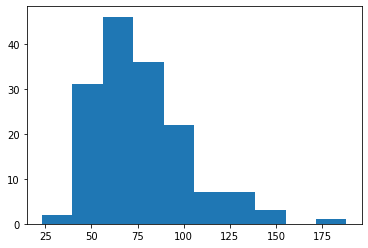

Mean:  77.04359120077419
Standard Deviation:  25.142664099182795


In [150]:
# look at the data to see properties, like normality:

from matplotlib import pyplot
import statistics

pyplot.hist(numbers)
pyplot.show()

mean = statistics.mean(numbers)
std = statistics.stdev(numbers)
median = statistics.median(numbers)
print("Mean: ", mean)
print("Standard Deviation: ", std)


# is mean greater then median?
if mean <= median:
  print("The mean is not greateer then the median. Your distribution might be" + 
        "off; Benford's Law might not apply...")


In [151]:
# process the raw list:
sig_list = ([x // (10**math.floor(math.log10(x))) for x in numbers])
print(sig_list[0:50])

# get Benford probabilities:
def benford (digit):
  return math.log10((digit + 1)/ digit)


[5.0, 9.0, 9.0, 6.0, 8.0, 1.0, 7.0, 8.0, 8.0, 7.0, 9.0, 8.0, 8.0, 1.0, 1.0, 1.0, 8.0, 1.0, 4.0, 6.0, 6.0, 7.0, 8.0, 1.0, 4.0, 2.0, 7.0, 6.0, 6.0, 8.0, 5.0, 1.0, 1.0, 5.0, 6.0, 6.0, 8.0, 1.0, 9.0, 7.0, 7.0, 4.0, 9.0, 6.0, 4.0, 7.0, 6.0, 6.0, 4.0, 8.0]


In [152]:
# calculate meta-statistics:

actual_freqs = Counter(sig_list)
print(actual_freqs)

limit = len(numbers)
print(limit)

predicted = []
for i in range(1, 10):
  pred_num = benford(i) * limit
  predicted.append(round(pred_num, 4))

benford_list = [1,2,3,4,5,6,7,8,9]

predicted_freqs = dict(zip(benford_list, predicted))

df = pd.DataFrame({'Predicted Values':pd.Series(predicted_freqs),'Actual Values':pd.Series(actual_freqs)})


# df["Predicted Proportion"] = df['Predicted Values'] / limit
# df["Actual Proportion"] = df['Actual Values'] / limit

df["Predicted Percent"] = (df['Predicted Values'] / limit) * 100
df["Actual Percent"] = (df['Actual Values']  / limit) * 100


print(df)

actual_props = list(df["Predicted Percent"])
predicted_props = list(df["Actual Percent"])


Counter({6.0: 29, 8.0: 29, 1.0: 25, 7.0: 21, 5.0: 18, 4.0: 17, 9.0: 13, 3.0: 2, 2.0: 1})
155
     Predicted Values  Actual Values  Predicted Percent  Actual Percent
1.0           46.6596             25          30.102968       16.129032
2.0           27.2941              1          17.609097        0.645161
3.0           19.3655              2          12.493871        1.290323
4.0           15.0211             17           9.691032       10.967742
5.0           12.2731             18           7.918129       11.612903
6.0           10.3768             29           6.694710       18.709677
7.0            8.9888             21           5.799226       13.548387
8.0            7.9286             29           5.115226       18.709677
9.0            7.0924             13           4.575742        8.387097


In [153]:
# create test statistic:
chi_squared = 0
for i in range(0,9):
  error = ((actual_props[i] - predicted_props[i]) ** 2) / predicted_props[i]
  chi_squared  = chi_squared + error

print(chi_squared)

580.51768406736


In [154]:
# conduct actual hypthesis test:
# H0: All digits 1-9 Conform to the predicted Benford's Law Proportion
# H1: At least 1 digit does not conform to the predictions.


dof = 8

value = 1 - stats.chi2.cdf(chi_squared, dof)
print( "P value: " ,value)
print( "Alpha: " , 0.05)


if value < 0.05:
  print("Results are significant at this Alpha Level (0.05). \nThis indicates " + 
        "very strong evidence that Benford's Law is NOT obeyed. H0 is rejected.")
else:
  print("Results are not statistically significant. \nThis indicates " + 
        "very strong evidence that Benford's Law IS obeyed. Fail to reject H0.")

P value:  0.0
Alpha:  0.05
Results are significant at this Alpha Level (0.05). 
This indicates very strong evidence that Benford's Law is NOT obeyed. H0 is rejected.


**History of Data Tested so Far:**

-- Dataset | Column | Chi-Squre Value | p-Value | Result -- 

1) NYC Property Sales, SALE PRICE, 6.0326, 0.64357, **Obeys**

2) Video Game Sales, NA_Sales, 28.801, 0.00034, **Does not Obey**

3) Video Game Sales, EU_Sales, 66.899, 2.029E-11, **Does not Obey**

4) Video Game Sales, JP_Sales, 81.6581, 2.264E-14, **Does not Obey**

5) Sample Sales Data, SALES, 30.505, 1.721E-4, **Does not Obey**

6) Sample Sales Data, QUANTITYORDERED, 2999.20, 0.0, **Does not Obey**

7) Car sales, Sales_in_thousands, 3.219, 0.9198, **Does not Obey**




**Links to Datasets:**

1) https://www.kaggle.com/new-york-city/nyc-property-sales

2, 3, 4) https://www.kaggle.com/gregorut/videogamesales

5, 6) https://www.kaggle.com/kyanyoga/sample-sales-data

7) https://www.kaggle.com/gagandeep16/car-sales
